In [2]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("../Supervisionado/dataset_delegacias")
# old_df = pd.read_csv("../dataset_ocorrencias_delegacia_5.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   orgao_responsavel      5000 non-null   object
 1   ano                    5000 non-null   int64 
 2   mes                    5000 non-null   int64 
 3   dia_semana_name        5000 non-null   object
 4   tipo_crime             5000 non-null   object
 5   quantidade_ocorrencia  5000 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 234.5+ KB


In [6]:
# Pré-processamento dos dados
dados = df[['tipo_crime', 'orgao_responsavel']].copy()

# Codificar as variáveis categóricas para números
le_crime = LabelEncoder()
le_orgao = LabelEncoder()

dados['tipo_crime_encoded'] = le_crime.fit_transform(dados['tipo_crime'])
dados['orgao_responsavel_encoded'] = le_orgao.fit_transform(dados['orgao_responsavel'])

# Mostrar o mapeamento
print("Mapeamento de crimes:")
for i, crime in enumerate(le_crime.classes_):
    print(f"  {i}: {crime}")

print("\nMapeamento de órgãos:")
for i, orgao in enumerate(le_orgao.classes_):
    print(f"  {i}: {orgao}")

Mapeamento de crimes:
  0: Ameaça
  1: Estelionato
  2: Estupro
  3: Furto
  4: Homicídio
  5: Latrocínio
  6: Roubo
  7: Sequestro
  8: Tráfico de Drogas
  9: Violência Doméstica

Mapeamento de órgãos:
  0: Delegacia Afogados
  1: Delegacia Boa Viagem
  2: Delegacia Casa Forte
  3: Delegacia Pina
  4: Delegacia Santo Amaro
  5: Delegacia Torre


In [7]:
X = dados[['tipo_crime_encoded', 'orgao_responsavel_encoded']].values

# Número de clusters igual ao número de tipos de crime únicos
n_clusters = len(df['tipo_crime'].unique())

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Adicionar os clusters ao dataframe
dados['cluster'] = clusters
df['cluster'] = clusters

print(f"KMeans aplicado com {n_clusters} clusters")
print(f"Distribuição dos clusters:")
print(dados['cluster'].value_counts().sort_index())

KMeans aplicado com 10 clusters
Distribuição dos clusters:
cluster
0    603
1    419
2    724
3    493
4    407
5    583
6    526
7    336
8    429
9    480
Name: count, dtype: int64


In [10]:
# Analisando os clusters 
print("SISTEMA DE RECOMENDAÇÃO DE ÓRGÃOS POR TIPO DE CRIME")
print("=" * 60)

# Para cada cluster, encontrar o órgão mais frequente
recomendacoes = {}

for cluster_id in range(n_clusters):
    cluster_data = dados[dados['cluster'] == cluster_id]
    
    # Encontrar o órgão mais comum neste cluster
    orgao_mais_comum = cluster_data['orgao_responsavel'].mode()[0]
    crimes_no_cluster = cluster_data['tipo_crime'].unique()
    
    recomendacoes[cluster_id] = {
        'orgao_recomendado': orgao_mais_comum,
        'crimes_envolvidos': crimes_no_cluster
    }
    
    print(f"\nCluster {cluster_id}:")
    print(f"   Órgão Recomendado: {orgao_mais_comum}")
    print(f"   Tipos de Crime: {', '.join(crimes_no_cluster)}")

SISTEMA DE RECOMENDAÇÃO DE ÓRGÃOS POR TIPO DE CRIME

Cluster 0:
   Órgão Recomendado: Delegacia Pina
   Tipos de Crime: Roubo, Sequestro, Latrocínio

Cluster 1:
   Órgão Recomendado: Delegacia Pina
   Tipos de Crime: Ameaça, Estupro, Estelionato

Cluster 2:
   Órgão Recomendado: Delegacia Boa Viagem
   Tipos de Crime: Sequestro, Tráfico de Drogas, Violência Doméstica

Cluster 3:
   Órgão Recomendado: Delegacia Torre
   Tipos de Crime: Furto, Latrocínio, Homicídio

Cluster 4:
   Órgão Recomendado: Delegacia Boa Viagem
   Tipos de Crime: Estupro, Furto

Cluster 5:
   Órgão Recomendado: Delegacia Torre
   Tipos de Crime: Violência Doméstica, Tráfico de Drogas, Sequestro

Cluster 6:
   Órgão Recomendado: Delegacia Boa Viagem
   Tipos de Crime: Homicídio, Latrocínio, Roubo

Cluster 7:
   Órgão Recomendado: Delegacia Afogados
   Tipos de Crime: Estelionato, Ameaça

Cluster 8:
   Órgão Recomendado: Delegacia Casa Forte
   Tipos de Crime: Homicídio, Furto, Latrocínio

Cluster 9:
   Órgão Recom

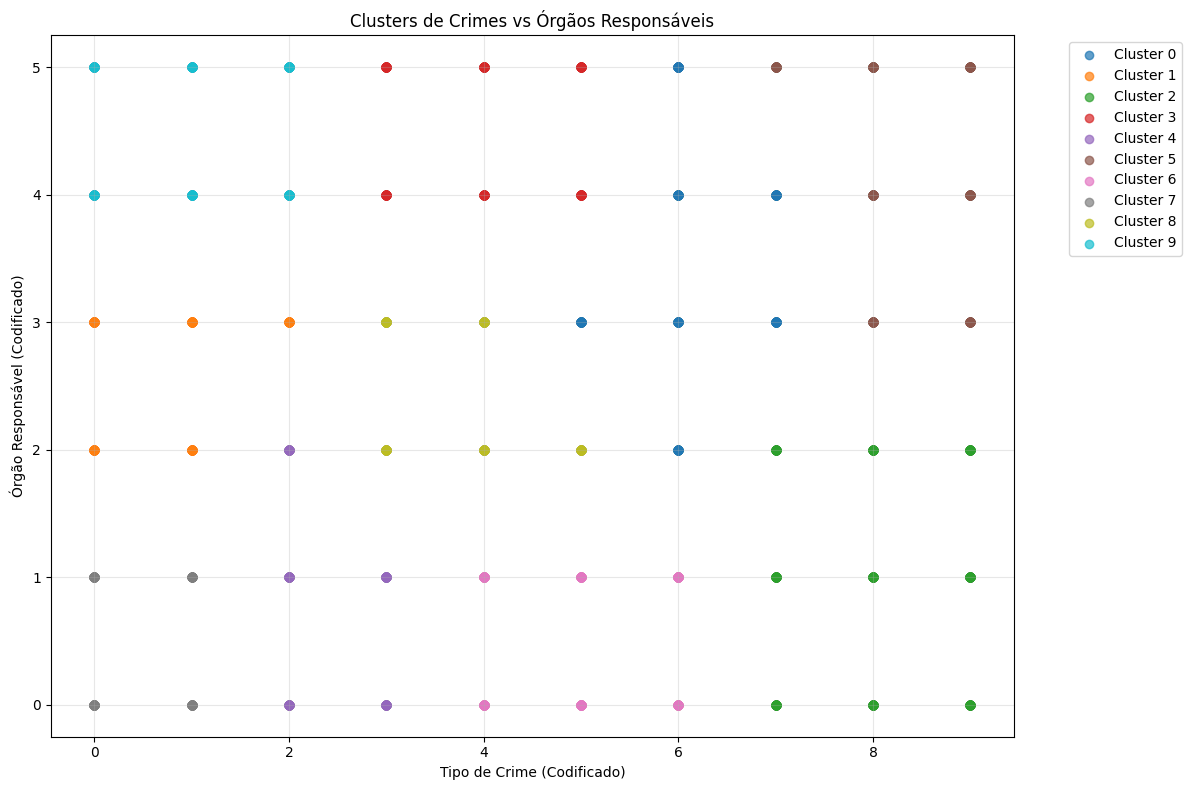

Gráfico gerado: Cada cor representa um cluster diferente


In [11]:
# Visualização dos clusters
plt.figure(figsize=(12, 8))

# Criar gráfico de dispersão
for cluster_id in range(n_clusters):
    cluster_data = dados[dados['cluster'] == cluster_id]
    plt.scatter(cluster_data['tipo_crime_encoded'], 
                cluster_data['orgao_responsavel_encoded'],
                label=f'Cluster {cluster_id}',
                alpha=0.7)

plt.xlabel('Tipo de Crime (Codificado)')
plt.ylabel('Órgão Responsável (Codificado)')
plt.title('Clusters de Crimes vs Órgãos Responsáveis')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Gráfico gerado: Cada cor representa um cluster diferente")

In [ ]:
# Função de recomendação simples
def recomendar_orgao(tipo_crime):
    """Recomenda o órgão mais adequado para um tipo de crime específico"""
    try:
        crime_encoded = le_crime.transform([tipo_crime])[0]
        
        crimes_do_tipo = dados[dados['tipo_crime_encoded'] == crime_encoded]
        
        if len(crimes_do_tipo) == 0:
            return "❌ Tipo de crime não encontrado"
        
        cluster_mais_comum = crimes_do_tipo['cluster'].mode()[0]
        
        orgao_recomendado = recomendacoes[cluster_mais_comum]['orgao_recomendado']
        
        return f"✅ Para o crime de '{tipo_crime}', recomenda-se: {orgao_recomendado}"
    
    except ValueError:
        return "❌ Tipo de crime não reconhecido"

print("\n🧪 TESTES DA FUNÇÃO DE RECOMENDAÇÃO:")
print(recomendar_orgao(df['tipo_crime'].iloc[0]))  # Primeiro crime da lista
print(recomendar_orgao(df['tipo_crime'].iloc[100])) # Um crime do meio


🧪 TESTES DA FUNÇÃO DE RECOMENDAÇÃO:
✅ Para o crime de 'Sequestro', recomenda-se: Delegacia Boa Viagem
✅ Para o crime de 'Homicídio', recomenda-se: Delegacia Casa Forte


In [ ]:
# Validar a qualidade do modelo

# Calcular quantas vezes a recomendação coincide com o órgão real
acertos = 0
total = len(df)

for idx, row in df.iterrows():
    crime = row['tipo_crime']
    orgao_real = row['orgao_responsavel']
    
    recomendacao_texto = recomendar_orgao(crime)
    orgao_recomendado = recomendacao_texto.split(": ")[-1] if "recomenda-se:" in recomendacao_texto else ""
    
    if orgao_recomendado == orgao_real:
        acertos += 1

acuracia = (acertos / total) * 100
print(f"Acurácia do modelo: {acuracia:.2f}%")
print(f"   ({acertos} acertos de {total} casos)")

if acuracia > 70:
    print("Modelo com boa performance!")
elif acuracia > 50:
    print("Modelo com performance moderada")
else:
    print("Modelo precisa de ajustes")

Acurácia do modelo: 17.46%
   (873 acertos de 5000 casos)
Modelo precisa de ajustes
